# History Matching L96
Author: Redouane Lguensat

Date: 26/07/2021

In [1]:
from L96 import * #https://github.com/raspstephan/Lorenz-Online
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
np.random.seed(42)

X_init = 10 * np.ones(36)
X_init[18] = 10 + 0.01

l96_two = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=X_init, integration_type='coupled') # True params J=10, h=1, F=10, c=10, b=10

In [3]:
l96_two.iterate(10)

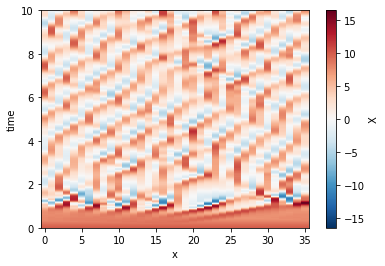

In [4]:
l96_two.history.X.plot()

#### take the last state as an init for a new simulation
since now we are sure that it starts from the attractor

In [5]:
Newinit = l96_two.history.X[-1,:].values
Newinit

array([ 2.60122824, -0.59213617, -1.17373327,  1.84938332,  8.68045117,
        3.46059218,  0.25781228,  1.2653452 ,  1.08225301,  0.8753893 ,
        8.97733208,  6.18802886,  1.94032476,  1.88401847,  4.37917481,
       -1.81942909, 10.94394167,  3.59440247, -1.43808455, -0.99906739,
       -0.49279472,  2.07853127, -0.63479542, 10.33846187,  5.62458241,
        1.20973551,  1.19944234, -3.27853949, -2.96779466,  4.56265636,
        7.60216092,  2.54621466,  0.40105946, -4.41037045,  1.36549073,
        7.4825951 ])

In [6]:
np.random.seed(42)

l96_two_truth = L96TwoLevelOriginal(K=36, save_dt=0.001, X_init=Newinit, integration_type='coupled') 

In [7]:
l96_two_truth.iterate(100)

This is our ground truth

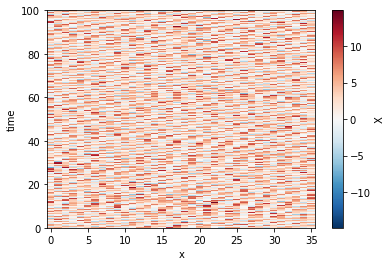

In [8]:
l96_two_truth.history.X.plot()

# Metrics

We will use the 5 terms depicted here as in Schneider et al. 2017. 

$$
\boldsymbol{f}(X, Y)=\left(\begin{array}{c}
X \\
\bar{Y} \\
X^{2} \\
X \bar{Y}\\
\bar{Y}^{2}
\end{array}\right)
$$

# History Matching

We want to find the parameters (h, F, c, b)

$\frac{d X_{k}}{d t}=\underbrace{-X_{k-1}\left(X_{k-2}-X_{k+1}\right)}_{\text {Advection}} \underbrace{-X_{k}}_{\text {Diffusion}}+\underbrace{F}_{\text {Forcing}} - \underbrace{\frac{h c}{b} \Sigma_j Y_{j,k}}_{\text {Coupling}}$

$ \frac{d Y_{j, k}}{d t}=\underbrace{-b c Y_{j+1, k}\left(Y_{j+2, k}-Y_{j-1, k}\right)}_{\text {Advection }} \underbrace{- c Y_{j, k}}_{\text {Diffusion }} \underbrace{+\frac{h c}{b} X_{k}}_{\text {Coupling }}$

# Wave1

calculate metrics for the true trajectory

In [9]:
TrueTraj = l96_two_truth.mean_stats(ax=0)

Define metric 

In [10]:
def metric(params):
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param_spinup.iterate(10)
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=l96param_spinup.history.X[-1,:].values,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param.mean_stats(ax=0)

Sanity check with the true params

In [11]:
#sancheck = metric(np.array([1,10,10,10]))

In [12]:
#np.mean((TrueTraj - sancheck)**2)

# Running the 40 simulations in parallel

In [13]:
inputs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_inputs_newPCA_PhysPrior_wave1.csv").values

In [14]:
inputs

array([[ 0.52467315,  4.37188699,  4.22945245,  5.7722604 ],
       [ 0.70536254, 12.94152131, 13.89887497,  4.98493049],
       [ 1.69603016, 10.47313125, 16.87757738,  8.73514183],
       [ 1.5120101 ,  5.12854426,  9.64119316,  1.60337253],
       [ 1.58267595,  6.10760006, 11.30897114, 14.57369939],
       [ 0.89421304, 15.10421297,  7.55533735,  9.37400613],
       [ 1.34443719, 18.09419077,  9.05736125, 14.92385033],
       [ 1.79877661,  0.59914535,  6.72280707,  7.50214096],
       [ 0.92410114, 17.57087224, 16.47321981, 16.45288618],
       [ 1.40480899, 11.84772418,  8.32485719, 10.38599737],
       [ 0.39652475, 13.66171279, 13.01020798, 10.80867553],
       [ 0.81581691,  6.69032991, 14.46395782, 15.48602008],
       [ 0.77349177, 14.37359081,  2.3901988 , 19.73652558],
       [ 0.9778027 ,  7.64059445,  5.23100374, 18.25227421],
       [ 1.49103124, 10.88091913, 19.98536436, 11.291125  ],
       [ 1.73179323, 16.03651207, 10.87961321,  6.22865667],
       [ 0.26825652, 16.

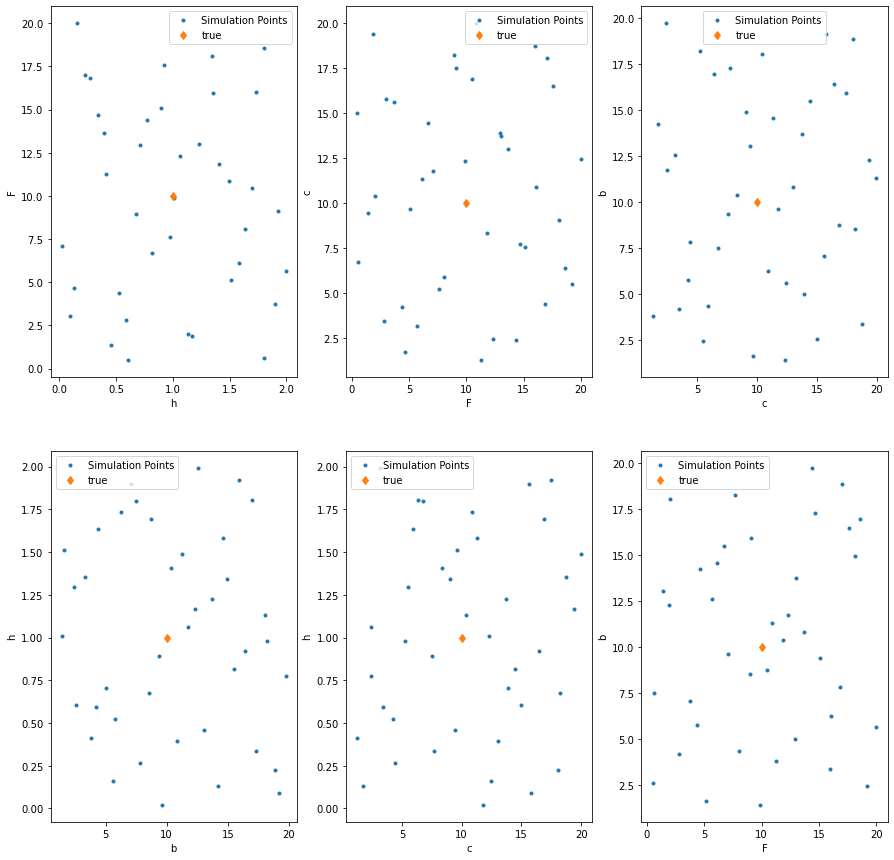

In [15]:
plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs[:,1], inputs[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs[:,0], inputs[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs[:,2], inputs[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs[:,3], inputs[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs[:,2], inputs[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs[:,1], inputs[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [16]:
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()
num_cores

80

In [17]:
import joblib
joblib.__version__

'1.0.0'

In [18]:
%%time

results = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs)

targets = np.array(results)

CPU times: user 286 ms, sys: 1.01 s, total: 1.29 s
Wall time: 2min 55s


In [19]:
inputs = inputs[np.all(np.isfinite(targets), axis=1)]
targets = targets[np.all(np.isfinite(targets), axis=1)]

In [20]:
targets.shape, inputs.shape

((40, 180), (40, 4))

# pca

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def reduceL96pca(vector):   
    scaler = StandardScaler().fit(vector)
    datascaled = scaler.transform(vector)
    TrueTrajscaled = scaler.transform(TrueTraj[None,:])
    ###########
    pca = PCA(n_components=0.99, svd_solver = 'full')
    pca.fit(datascaled)
    reduceddata = pca.transform(datascaled)
    reducedTrueTraj = pca.transform(TrueTrajscaled)
    return reduceddata, reducedTrueTraj, scaler, pca

In [22]:
targetsreduced, Obsreduced, sc, pc = reduceL96pca(targets)
targetsreduced.shape, Obsreduced.shape

((40, 5), (1, 5))

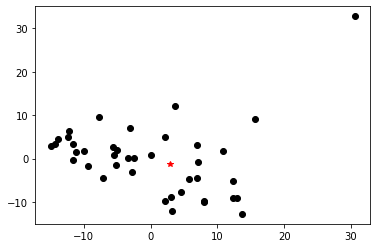

In [23]:
plt.scatter(targetsreduced[:,0],targetsreduced[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

### save dataframes

In [23]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave1.csv', index=False)

In [24]:
df_metrics

,pca_0,pca_1,pca_2,pca_3,pca_4
0,-5.613217,2.671021,-0.043014,-1.510025,-0.391253
1,6.909158,3.034623,-0.604677,-3.326809,-1.296989
2,2.155878,5.074132,-2.048263,-2.184390,2.163727
3,-13.936713,4.452221,3.016074,0.991144,-1.329736
4,-5.544478,0.878579,-1.503463,-0.620815,-0.282383
5,12.277960,-5.261998,0.865331,-2.012443,-2.363227
6,12.263824,-9.059795,1.522885,0.824590,-1.213589
7,-14.388397,3.317954,2.410601,1.204357,-2.291565
8,7.968418,-9.994549,0.759870,1.272833,0.834633
9,7.052796,-0.910441,-1.131194,-1.641211,-1.652673


In [25]:
df_obs_nonoise = pd.DataFrame()
for i in range(targetsreduced.shape[1]):
    df_obs_nonoise['pca_'+str(i)] = Obsreduced[:,i]
df_obs_nonoise.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_obs_nonoise_newPCA_PhysPrior_wave1.csv', index=False)

## 2) wave 2

In [26]:
inputs2 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave2.csv").values

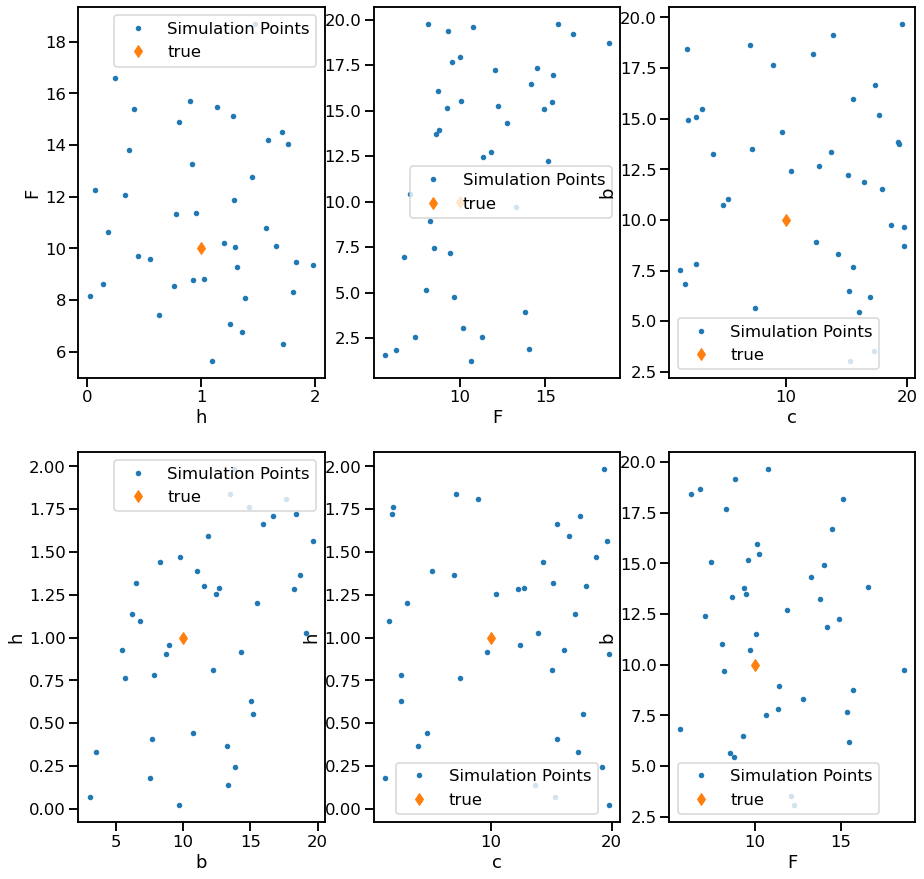

In [27]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs2[:,1], inputs2[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs2[:,0], inputs2[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs2[:,2], inputs2[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs2[:,3], inputs2[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs2[:,2], inputs2[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs2[:,1], inputs2[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [28]:
inputs2.shape

(40, 4)

In [29]:
%%time

results2 = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs2)

targets2 = np.array(results2)

CPU times: user 68 ms, sys: 2.17 ms, total: 70.1 ms
Wall time: 2min 54s


In [30]:
inputs2 = inputs2[np.all(np.isfinite(targets2), axis=1)]
targets2 = targets2[np.all(np.isfinite(targets2), axis=1)]

In [23]:
def reduceL96pca_usingwave1(vector, scaler, pca): 
    datascaled = scaler.transform(vector)
    return pca.transform(datascaled)

In [32]:
#targetsreduced2, Obsreduced2, sc2, pc2 = reduceL96pca(targets2)
targetsreduced2 = reduceL96pca_usingwave1(targets2, sc, pc)
targetsreduced2.shape

(40, 5)

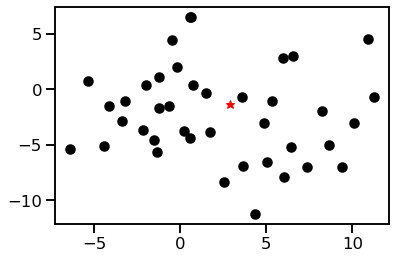

In [33]:
plt.scatter(targetsreduced2[:,0],targetsreduced2[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

In [34]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced2.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced2[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave2.csv', index=False)

# wave3

In [35]:
inputs3 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave3.csv").values

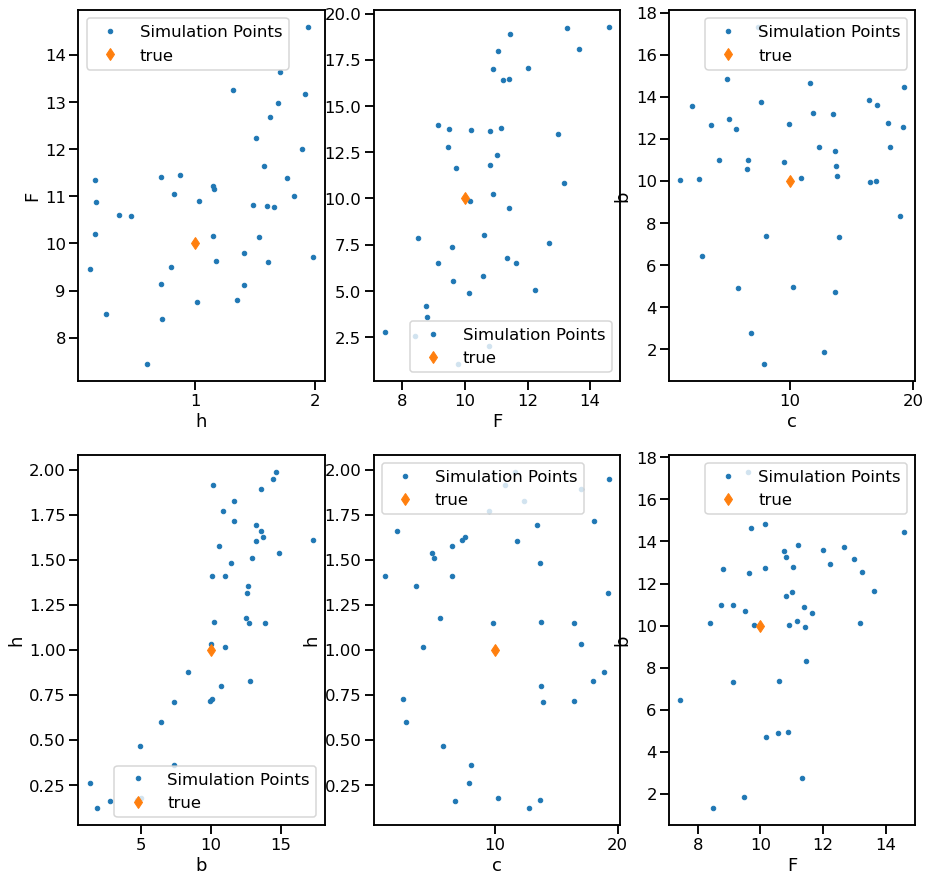

In [36]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs3[:,1], inputs3[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs3[:,0], inputs3[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs3[:,2], inputs3[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs3[:,3], inputs3[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs3[:,2], inputs3[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs3[:,1], inputs3[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [37]:
inputs3.shape

(40, 4)

In [38]:
%%time

results3 = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs3)

targets3 = np.array(results3)

CPU times: user 153 ms, sys: 403 ms, total: 556 ms
Wall time: 2min 54s


In [39]:
inputs3.shape, targets3.shape

((40, 4), (40, 180))

In [40]:
inputs3 = inputs3[np.all(np.isfinite(targets3), axis=1)]
targets3 = targets3[np.all(np.isfinite(targets3), axis=1)]

In [41]:
inputs3.shape, targets3.shape

((40, 4), (40, 180))

In [42]:
targetsreduced3 = reduceL96pca_usingwave1(targets3, sc, pc)
targetsreduced3.shape

(40, 5)

In [43]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced3.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced3[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave3.csv', index=False)

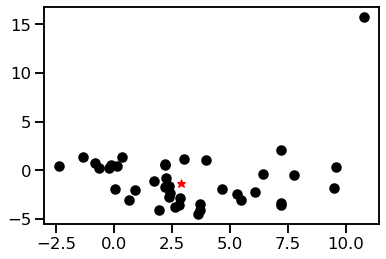

In [44]:
plt.scatter(targetsreduced3[:,0],targetsreduced3[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave4

In [45]:
inputs4 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave4.csv").values

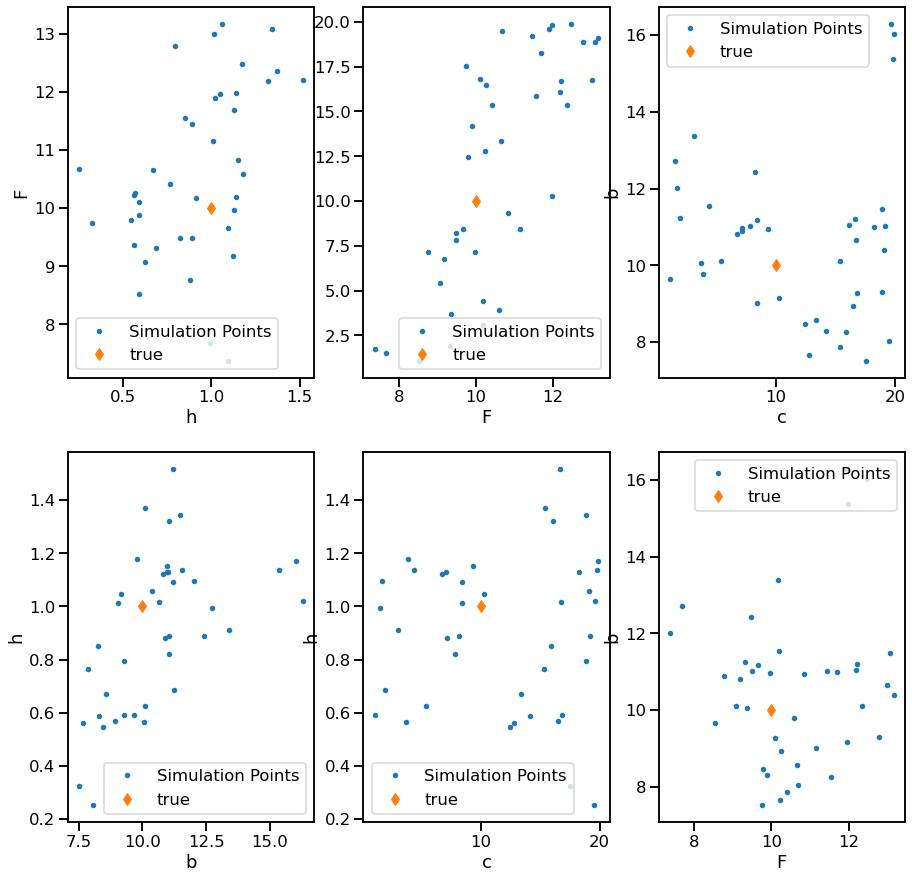

In [46]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs4[:,1], inputs4[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs4[:,0], inputs4[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs4[:,2], inputs4[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs4[:,3], inputs4[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs4[:,2], inputs4[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs4[:,1], inputs4[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [47]:
inputs4.shape

(40, 4)

In [48]:
%%time

results4 = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs4)

targets4 = np.array(results4)

CPU times: user 153 ms, sys: 393 ms, total: 546 ms
Wall time: 2min 53s


In [49]:
inputs4.shape, targets4.shape

((40, 4), (40, 180))

In [50]:
inputs4 = inputs4[np.all(np.isfinite(targets4), axis=1)]
targets4 = targets4[np.all(np.isfinite(targets4), axis=1)]

In [51]:
inputs4.shape, targets4.shape

((40, 4), (40, 180))

In [52]:
targetsreduced4 = reduceL96pca_usingwave1(targets4, sc, pc)
targetsreduced4.shape

(40, 5)

In [53]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced4.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced4[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave4.csv', index=False)

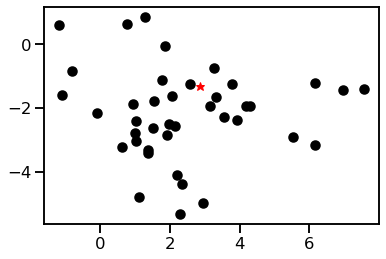

In [54]:
plt.scatter(targetsreduced4[:,0],targetsreduced4[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave5

In [55]:
inputs5 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave5.csv").values

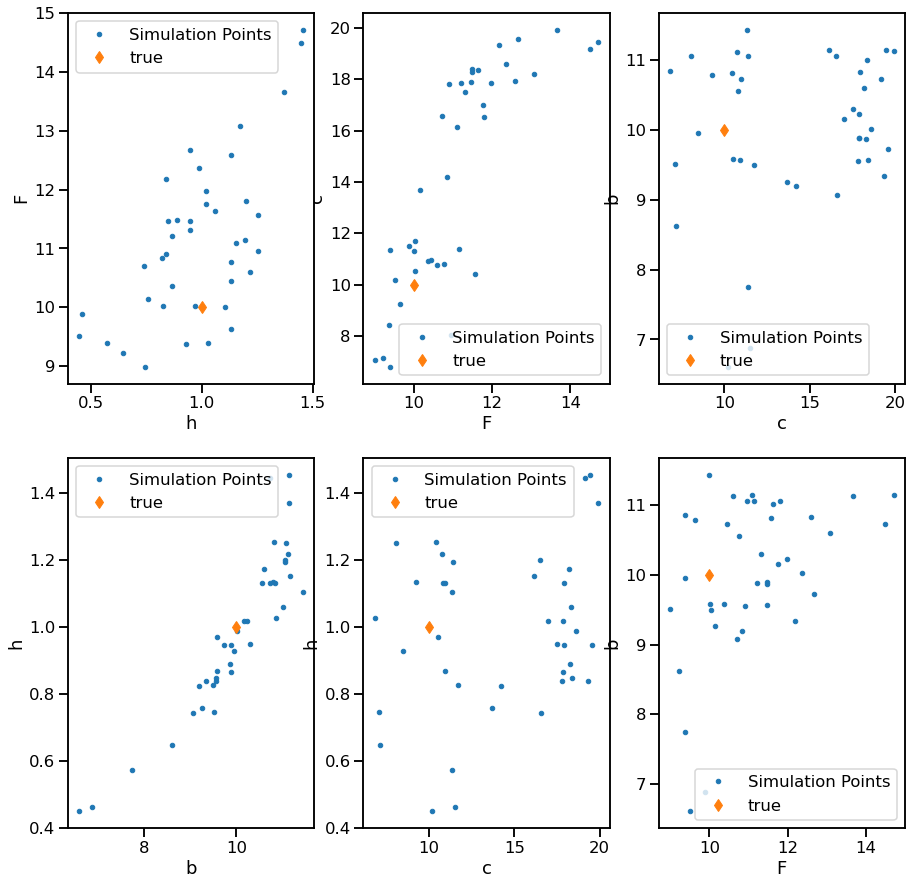

In [56]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs5[:,1], inputs5[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs5[:,0], inputs5[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs5[:,2], inputs5[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs5[:,3], inputs5[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs5[:,2], inputs5[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs5[:,1], inputs5[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [57]:
inputs5.shape

(40, 4)

In [58]:
%%time

results5 = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs5)

targets5 = np.array(results5)

CPU times: user 155 ms, sys: 418 ms, total: 574 ms
Wall time: 2min 52s


In [59]:
inputs5.shape, targets5.shape

((40, 4), (40, 180))

In [60]:
inputs5 = inputs5[np.all(np.isfinite(targets5), axis=1)]
targets5 = targets5[np.all(np.isfinite(targets5), axis=1)]

In [61]:
inputs5.shape, targets5.shape

((40, 4), (40, 180))

In [62]:
targetsreduced5 = reduceL96pca_usingwave1(targets5, sc, pc)
targetsreduced5.shape

(40, 5)

In [63]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced5.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced5[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave5.csv', index=False)

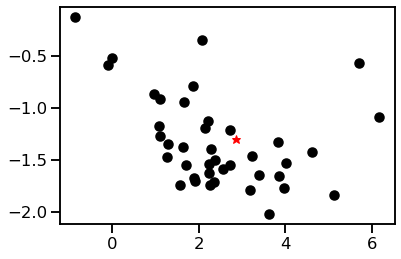

In [64]:
plt.scatter(targetsreduced5[:,0],targetsreduced5[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# wave6

In [92]:
inputs6 = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/exp_TuningL94_newPCA_PhysPrior_wave6.csv").values

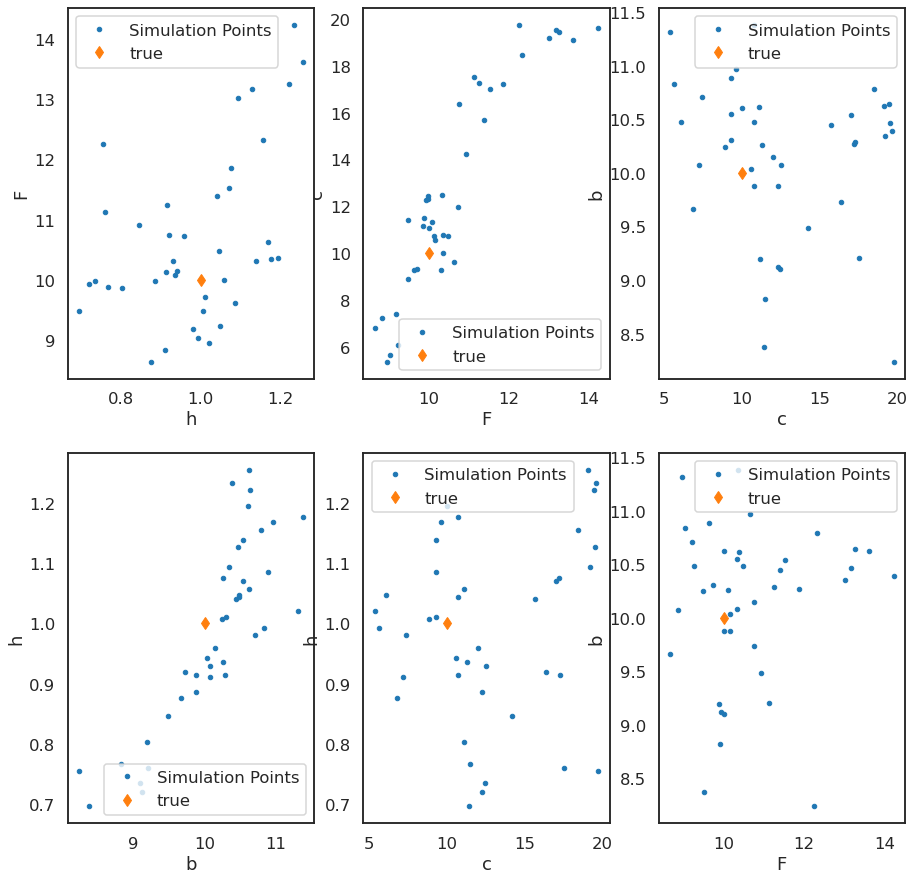

In [93]:
sns.set_context("talk")

plt.figure(figsize=(15,15))

plt.subplot(2,3,2)
plt.plot(inputs6[:,1], inputs6[:,2], ".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("c")
plt.legend()


plt.subplot(2,3,1)
plt.plot(inputs6[:,0], inputs6[:,1],".", label="Simulation Points")
plt.plot(1, 10,"d", label="true")
plt.xlabel("h")
plt.ylabel("F")
plt.legend()

plt.subplot(2,3,3)
plt.plot(inputs6[:,2], inputs6[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("c")
plt.ylabel("b")
plt.legend()

plt.subplot(2,3,4)
plt.plot(inputs6[:,3], inputs6[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("b")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,5)
plt.plot(inputs6[:,2], inputs6[:,0],".", label="Simulation Points")
plt.plot(10, 1,"d", label="true")
plt.xlabel("c")
plt.ylabel("h")
plt.legend()

plt.subplot(2,3,6)
plt.plot(inputs6[:,1], inputs6[:,3],".", label="Simulation Points")
plt.plot(10, 10,"d", label="true")
plt.xlabel("F")
plt.ylabel("b")
plt.legend()

In [94]:
inputs6.shape

(40, 4)

In [95]:
%%time

results6 = Parallel(n_jobs=60)(delayed(metric)(i) for i in inputs6)

targets6 = np.array(results6)

CPU times: user 297 ms, sys: 2.82 s, total: 3.12 s
Wall time: 2min 58s


In [96]:
inputs6.shape, targets6.shape

((40, 4), (40, 180))

In [97]:
inputs6 = inputs6[np.all(np.isfinite(targets6), axis=1)]
targets6 = targets6[np.all(np.isfinite(targets6), axis=1)]

In [98]:
inputs6.shape, targets6.shape

((40, 4), (40, 180))

In [99]:
targetsreduced6 = reduceL96pca_usingwave1(targets6, sc, pc)
targetsreduced6.shape

(40, 5)

In [100]:
df_metrics = pd.DataFrame()
for i in range(targetsreduced6.shape[1]):
    df_metrics['pca_'+str(i)] = targetsreduced6[:,i]
df_metrics.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/df_metrics_newPCA_PhysPrior_wave6.csv', index=False)

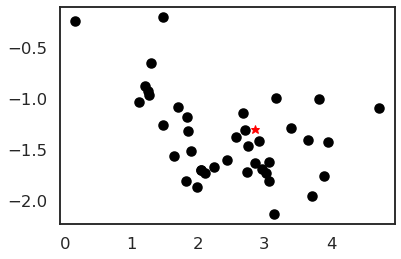

In [101]:
plt.scatter(targetsreduced6[:,0],targetsreduced6[:,1], color='k')
plt.plot(Obsreduced[:,0],Obsreduced[:,1], 'r*')

# Simulate the L96 configurations

In [24]:
def simulate(params):
    l96param_spinup = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=X_init,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param_spinup.iterate(10)
    l96param = L96TwoLevelOriginal(K=36,
                           save_dt=0.001,
                           X_init=l96param_spinup.history.X[-1,:].values,
                           h=params[0],
                           F=params[1],
                           c=params[2],
                           b=params[3],
                           integration_type='coupled') 
    l96param.iterate(100)
    return l96param

In [25]:
configs = pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA_PhysPrior.csv").values
configs.tolist()

[[1.05322213681883, 9.86743595197782, 9.05665949389613, 10.5201464007741],
 [0.807427741451389, 10.0627725965378, 11.4587362154879, 9.29522559524776],
 [1.11071439503139, 12.1303525780203, 17.1005143608833, 10.4807093622101]]

In [26]:
#pd.read_csv("/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/finaltestpoints_newPCA.csv").to_latex()

In [27]:
simus = [simulate(i) for i in configs.tolist()]

In [28]:
simus_metrics = [ii.mean_stats(ax=0) for ii in simus]

In [29]:
simus_metrics = np.array(simus_metrics)
simus_metrics.shape

(3, 180)

In [30]:
simusreduced = reduceL96pca_usingwave1(simus_metrics, sc, pc)
simusreduced.shape

(3, 5)

In [31]:
simus_df = pd.DataFrame()

for i in range(simusreduced.shape[1]):
    simus_df['pc'+str(i)] = simusreduced[:,i]
    
#simus_df.to_csv('/gpfswork/rech/omr/udu91zn/HighTune_R/Data/JAMES/configs_metrics_newPCA_PhysPrior.csv', index=False)

In [32]:
simus_df

,pc0,pc1,pc2,pc3,pc4
0,2.445275,-1.370004,-1.522563,-1.649084,-0.646016
1,1.983754,-1.465622,-1.227825,-2.000123,-0.466257
2,2.035874,-0.947120,-1.266921,-1.568238,-0.761798


### add obs vector

In [33]:
simus_df.loc[len(simus_df)]=list(Obsreduced[0,:])

In [34]:
simus_df

,pc0,pc1,pc2,pc3,pc4
0,2.445275,-1.370004,-1.522563,-1.649084,-0.646016
1,1.983754,-1.465622,-1.227825,-2.000123,-0.466257
2,2.035874,-0.947120,-1.266921,-1.568238,-0.761798
3,2.864049,-1.300404,-1.532052,-1.830526,-0.521380


In [35]:
simusdftranspose = simus_df.T
simusdftranspose.columns = ['config1', 'config2', 'config3', 'Obs']
simusdftranspose

,config1,config2,config3,Obs
pc0,2.445275,1.983754,2.035874,2.864049
pc1,-1.370004,-1.465622,-0.947120,-1.300404
pc2,-1.522563,-1.227825,-1.266921,-1.532052
pc3,-1.649084,-2.000123,-1.568238,-1.830526
pc4,-0.646016,-0.466257,-0.761798,-0.521380


Text(0.5, 0, '$\\bar{Y^2}$')

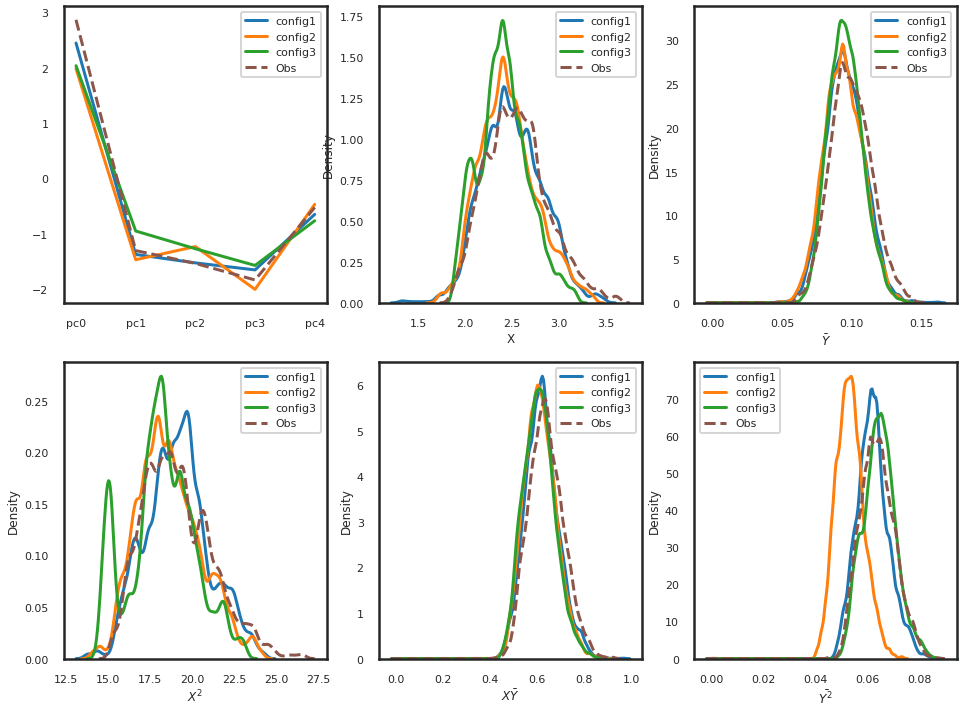

In [37]:
sns.set_style("white")
sns.set_context("poster", font_scale=0.5, rc={"lines.linewidth": 3})

figure, axes = plt.subplots(2, 3, figsize=(16,12))
simusdftranspose['config1'].plot(ax=axes[0,0])
simusdftranspose['config2'].plot(ax=axes[0,0])
simusdftranspose['config3'].plot(ax=axes[0,0])
simusdftranspose['Obs'].plot(linestyle="--", color='tab:brown', ax=axes[0,0])
axes[0,0].legend()

sns.kdeplot(simus[0].history.X.mean(axis=1), label='config1', ax=axes[0,1])
sns.kdeplot(simus[1].history.X.mean(axis=1), label='config2', ax=axes[0,1])
sns.kdeplot(simus[2].history.X.mean(axis=1), label='config3', ax=axes[0,1])
sns.kdeplot(l96_two_truth.history.X.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[0,1])
axes[0,1].legend()

sns.kdeplot(simus[0].history.Y_mean.mean(axis=1), label='config1', ax=axes[0,2])
sns.kdeplot(simus[1].history.Y_mean.mean(axis=1), label='config2', ax=axes[0,2])
sns.kdeplot(simus[2].history.Y_mean.mean(axis=1), label='config3', ax=axes[0,2])
sns.kdeplot(l96_two_truth.history.Y_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[0,2])
axes[0,2].legend()
axes[0,2].set_xlabel(r'$\bar{Y}$')

sns.kdeplot((simus[0].history.X**2).mean(axis=1), label='config1', ax=axes[1,0])
sns.kdeplot((simus[1].history.X**2).mean(axis=1), label='config2', ax=axes[1,0])
sns.kdeplot((simus[2].history.X**2).mean(axis=1), label='config3', ax=axes[1,0])
sns.kdeplot((l96_two_truth.history.X**2).mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[1,0])
axes[1,0].legend()
axes[1,0].set_xlabel(r'$X^2$')

sns.kdeplot((simus[0].history.X*simus[0].history.Y_mean).mean(axis=1), label='config1', ax=axes[1,1])
sns.kdeplot((simus[1].history.X*simus[1].history.Y_mean).mean(axis=1), label='config2', ax=axes[1,1])
sns.kdeplot((simus[2].history.X*simus[2].history.Y_mean).mean(axis=1), label='config3', ax=axes[1,1])
sns.kdeplot((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1), color='tab:brown', label='Obs', linestyle="--", ax=axes[1,1])
axes[1,1].legend()
axes[1,1].set_xlabel(r'$X\bar{Y}$')

sns.kdeplot(simus[0].history.Y2_mean.mean(axis=1), label='config1', ax=axes[1,2])
sns.kdeplot(simus[1].history.Y2_mean.mean(axis=1), label='config2', ax=axes[1,2])
sns.kdeplot(simus[2].history.Y2_mean.mean(axis=1), label='config3', ax=axes[1,2])
sns.kdeplot(l96_two_truth.history.Y2_mean.mean(axis=1), label='Obs', color='tab:brown', linestyle="--", ax=axes[1,2])
axes[1,2].legend()
axes[1,2].set_xlabel(r'$\bar{Y^2}$')

In [78]:
bx_df = pd.DataFrame()
bx_df['config1'] = simus[0].history.X.mean(axis=0)
bx_df['config2'] = simus[1].history.X.mean(axis=0)
bx_df['config3'] = simus[2].history.X.mean(axis=0)
bx_df['AvgConfig'] = (1/3)*(simus[0].history.X.mean(axis=0)+
                          simus[1].history.X.mean(axis=0)+
                         simus[2].history.X.mean(axis=0))
bx_df['Obs'] = TrueTraj[:36,]

<AxesSubplot:>

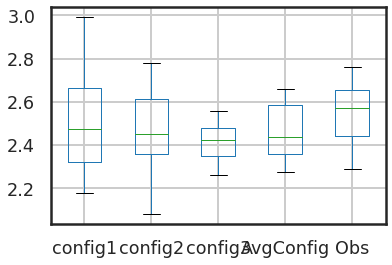

In [79]:
bx_df.boxplot()

<AxesSubplot:>

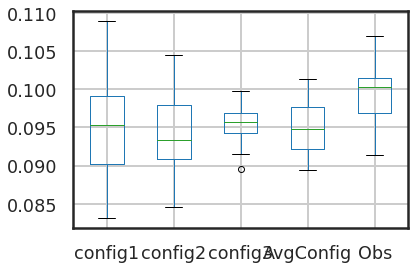

In [80]:
bx_df_Ymean = pd.DataFrame()
bx_df_Ymean['config1'] = simus[0].history.Y_mean.mean(axis=0)
bx_df_Ymean['config2'] = simus[1].history.Y_mean.mean(axis=0)
bx_df_Ymean['config3'] = simus[2].history.Y_mean.mean(axis=0)
bx_df_Ymean['AvgConfig'] = (1/3)*(simus[0].history.Y_mean.mean(axis=0)+
                                simus[1].history.Y_mean.mean(axis=0)+
                               simus[2].history.Y_mean.mean(axis=0))
bx_df_Ymean['Obs'] = TrueTraj[36:36*2,]
bx_df_Ymean.boxplot()

<AxesSubplot:>

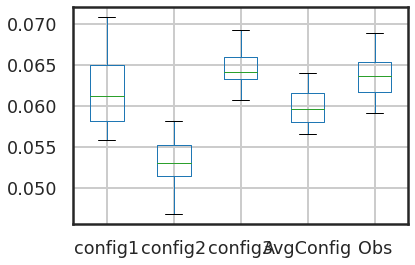

In [89]:
bx_df_Ysqmean = pd.DataFrame()
bx_df_Ysqmean['config1'] = simus_metrics[0,36*4:36*5]
bx_df_Ysqmean['config2'] = simus_metrics[1,36*4:36*5]
bx_df_Ysqmean['config3'] = simus_metrics[2,36*4:36*5]
bx_df_Ysqmean['AvgConfig'] = (1/3)*(simus_metrics[0,36*4:36*5]+
                                simus_metrics[1,36*4:36*5]+
                               simus_metrics[2,36*4:36*5])
bx_df_Ysqmean['Obs'] = TrueTraj[36*4:36*5,]
bx_df_Ysqmean.boxplot()

<AxesSubplot:>

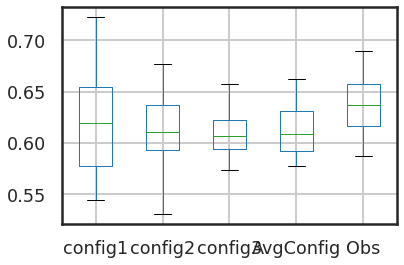

In [90]:
bx_df_XYmean = pd.DataFrame()
bx_df_XYmean['config1'] = simus_metrics[0,36*3:36*4]
bx_df_XYmean['config2'] = simus_metrics[1,36*3:36*4]
bx_df_XYmean['config3'] = simus_metrics[2,36*3:36*4]
bx_df_XYmean['AvgConfig'] = (1/3)*(simus_metrics[0,36*3:36*4]+
                                simus_metrics[1,36*3:36*4]+
                               simus_metrics[2,36*3:36*4])
bx_df_XYmean['Obs'] = TrueTraj[36*3:36*4,]
bx_df_XYmean.boxplot()

In [42]:
from scipy.stats import entropy

def KL_div_obs(sim):
    rangex=(l96_two_truth.history.X.mean(axis=1).min().values,
       l96_two_truth.history.X.mean(axis=1).max().values)
    rangeym=(l96_two_truth.history.Y_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y_mean.mean(axis=1).max().values)
    rangexsq=((l96_two_truth.history.X**2).mean(axis=1).min().values,
       (l96_two_truth.history.X**2).mean(axis=1).max().values)
    rangexym=((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).min().values,
       (l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1).max().values)
    rangeymsq=(l96_two_truth.history.Y2_mean.mean(axis=1).min().values,
       l96_two_truth.history.Y2_mean.mean(axis=1).max().values)
    return np.median([entropy(np.histogram(sim.history.X.mean(axis=1), range=rangex)[0],
                          np.histogram(l96_two_truth.history.X.mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y_mean.mean(axis=1), range=rangeym)[0],
                          np.histogram(l96_two_truth.history.Y_mean.mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X**2).mean(axis=1), range=rangexsq)[0],
                          np.histogram((l96_two_truth.history.X**2).mean(axis=1))[0]),
                  entropy(np.histogram((sim.history.X*sim.history.Y_mean).mean(axis=1), range=rangexym)[0],
                          np.histogram((l96_two_truth.history.X*l96_two_truth.history.Y_mean).mean(axis=1))[0]),
                  entropy(np.histogram(sim.history.Y2_mean.mean(axis=1), range=rangeymsq)[0],
                          np.histogram(l96_two_truth.history.Y2_mean.mean(axis=1))[0])])

In [37]:
[KL_div_obs(sim) for sim in simus]

[0.029651100506541003, 0.31010160158297995, 0.06850267980774857]

In [43]:
[KL_div_obs(sim) for sim in simus]

[0.03108088105665361, 0.05326569448068367, 0.07226412454691104]